### Importing packages

In [2]:
import random
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm
from time import time

### Simulation Parameters

In [12]:
RADIUS = 1
NUM_SAMPLES = 2000
RADIUS_LIST = [0.01, 0.1, 1, 10, 100, 1000, 10000]

### Gibbs sampler

In [13]:
def gibbs_sampler(initial_point=[0,0], M=1000, radius=RADIUS):
    
    x, y = initial_point
    
    sample = np.zeros(shape=[M, 2])
    sample[0] = initial_point

    for i in range(1, M):
        
        # p(x|y)
        x=random.uniform(a=-math.sqrt(radius**2 - y**2), b=math.sqrt(radius**2 - y**2)) 
        
        # p(y|x)
        y=random.uniform(a=-math.sqrt(radius**2 - x**2), b=math.sqrt(radius**2 - x**2))
        
        sample[i] = [x, y]
        
    return sample

### Sampling inside the Circle of Radius 1

In [14]:
point_one_sample = gibbs_sampler(M=NUM_SAMPLES)
point_two_sample = gibbs_sampler(M=NUM_SAMPLES)

### Visualizing Sampling results

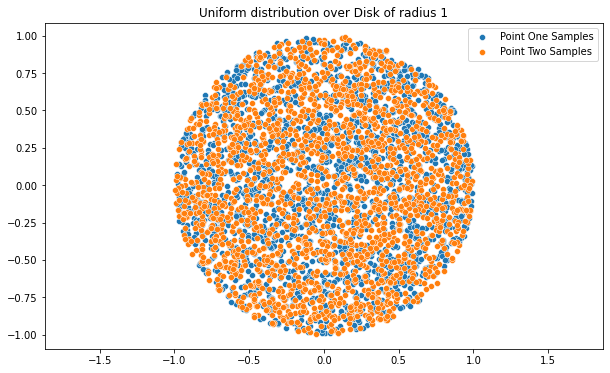

In [15]:
plt.figure(figsize=(10, 6))
g = sns.scatterplot(x=point_one_sample[:, 0], y=point_one_sample[:, 1], label='Point One Samples')
g = sns.scatterplot(x=point_two_sample[:, 0], y=point_two_sample[:, 1], label='Point Two Samples')
plt.axis('equal')
plt.title(f'Uniform distribution over Disk of radius {RADIUS}')
plt.legend();

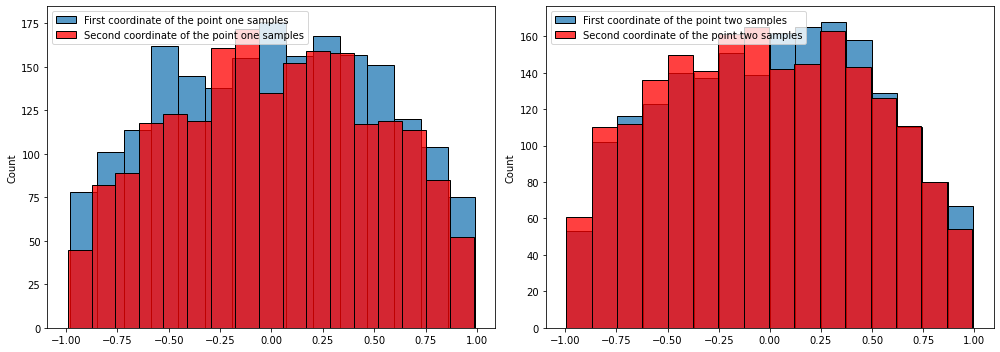

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), tight_layout=True)

sns.histplot(point_one_sample[:, 0], label='First coordinate of the point one samples', ax=ax[0])
sns.histplot(point_one_sample[:, 1], label='Second coordinate of the point one samples', ax=ax[0], color='r')
ax[0].legend();

sns.histplot(point_two_sample[:, 0], label='First coordinate of the point two samples', ax=ax[1])
sns.histplot(point_two_sample[:, 1], label='Second coordinate of the point two samples', ax=ax[1], color='r')
ax[1].legend();

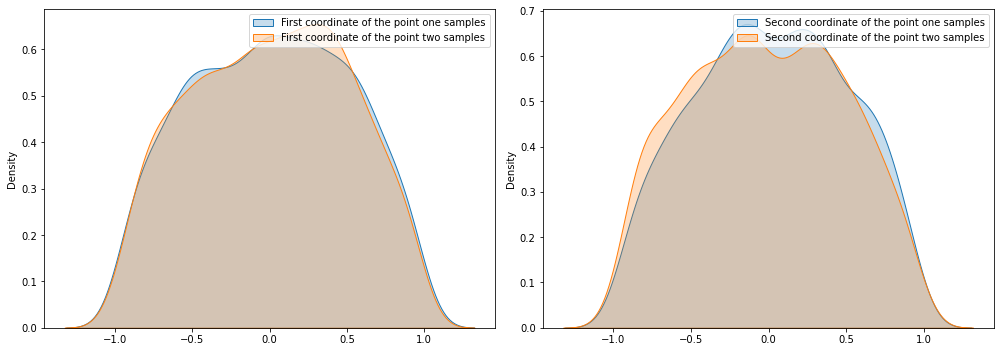

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), tight_layout=True)

sns.kdeplot(point_one_sample[:, 0], shade=True, label='First coordinate of the point one samples', ax=ax[0])
sns.kdeplot(point_two_sample[:, 0], shade=True, label='First coordinate of the point two samples', ax=ax[0])
ax[0].legend();

sns.kdeplot(point_one_sample[:, 1], shade=True, label='Second coordinate of the point one samples', ax=ax[1])
sns.kdeplot(point_two_sample[:, 1], shade=True, label='Second coordinate of the point two samples', ax=ax[1])
ax[1].legend();

### Calculating Empirical Distance

In [18]:
empirical_distance = np.linalg.norm(point_one_sample - point_two_sample, axis=1)

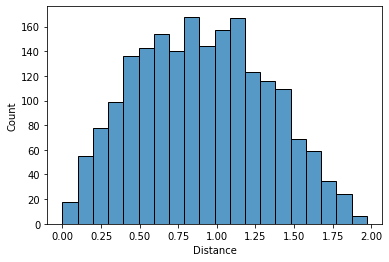

In [19]:
g = sns.histplot(empirical_distance);
plt.xlabel('Distance');

### Generating Results table

In [20]:
def true_distance(radius):
    return 128 * radius / (45 * np.pi)

In [21]:
def run_experiment_for_different_radius(num_samples, radius_list):
    
    np.random.seed(42)
    
    results = pd.DataFrame(
        data=[], 
        columns=['I', 'Estimator', 'Variance', 'Bias', 'Monte Carlo Standart Error (MCSE)', 'Execution Time']
    )
    execution_time = []
    for radius in tqdm(radius_list):
        start = time()
        
        point_one = gibbs_sampler(radius=radius)
        point_two = gibbs_sampler(radius=radius)

        empirical_distance = np.linalg.norm(point_one - point_two, axis=1) 
        I = true_distance(radius)
        
        results.loc[radius] = [
            I,
            np.mean(empirical_distance),
            np.var(empirical_distance),
            np.mean(empirical_distance) - I,
            np.std(empirical_distance) / num_samples,
            time() - start
        ]
        
        end = time()
        execution_time.append(end - start)
        
    return results, execution_time

In [22]:
results, execution_time = run_experiment_for_different_radius(num_samples=500, radius_list=RADIUS_LIST)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 96.14it/s]


In [23]:
results

,I,Estimator,Variance,Bias,Monte Carlo Standart Error (MCSE),Execution Time
0.01,0.009054,0.009109,1.888947e-05,0.000055,0.000009,0.009306
0.10,0.090541,0.093088,1.799142e-03,0.002547,0.000085,0.005279
1.00,0.905415,0.880805,1.825195e-01,-0.024610,0.000854,0.007304
10.00,9.054148,8.909771,1.827080e+01,-0.144377,0.008549,0.008181
100.00,90.541479,90.524662,1.924589e+03,-0.016817,0.087740,0.009527
1000.00,905.414787,898.960282,1.910762e+05,-6.454505,0.874245,0.007660
10000.00,9054.147874,8848.623663,1.777365e+07,-205.524211,8.431760,0.008163


### Experiments varying the sample size and radius 

In [24]:
sample_size_list = np.arange(1, 501, 1)

In [25]:
def run_experiment_for_diferents_sample_size(sample_size_list, radius):
    
    estimator_list = []
    error_list = []
    var_list = []
    bias_list = []
    for sample_size in tqdm(sample_size_list):

        point_one = gibbs_sampler(M=sample_size, radius=radius)
        point_two = gibbs_sampler(M=sample_size, radius=radius)

        empirical_distance = np.linalg.norm(point_one - point_two, axis=1) 
        
        estimator = np.mean(empirical_distance)
        error = np.abs(estimator - true_distance(radius))
        var = np.var(empirical_distance)
        bias = estimator - true_distance(radius)
        
        estimator_list.append(estimator)
        error_list.append(error)
        var_list.append(var)
        bias_list.append(bias)
        
    return estimator_list, error_list, var_list, bias_list

In [26]:
results = {
    radius: run_experiment_for_diferents_sample_size(sample_size_list, radius) 
    for radius in RADIUS_LIST
}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 579.38it/s]


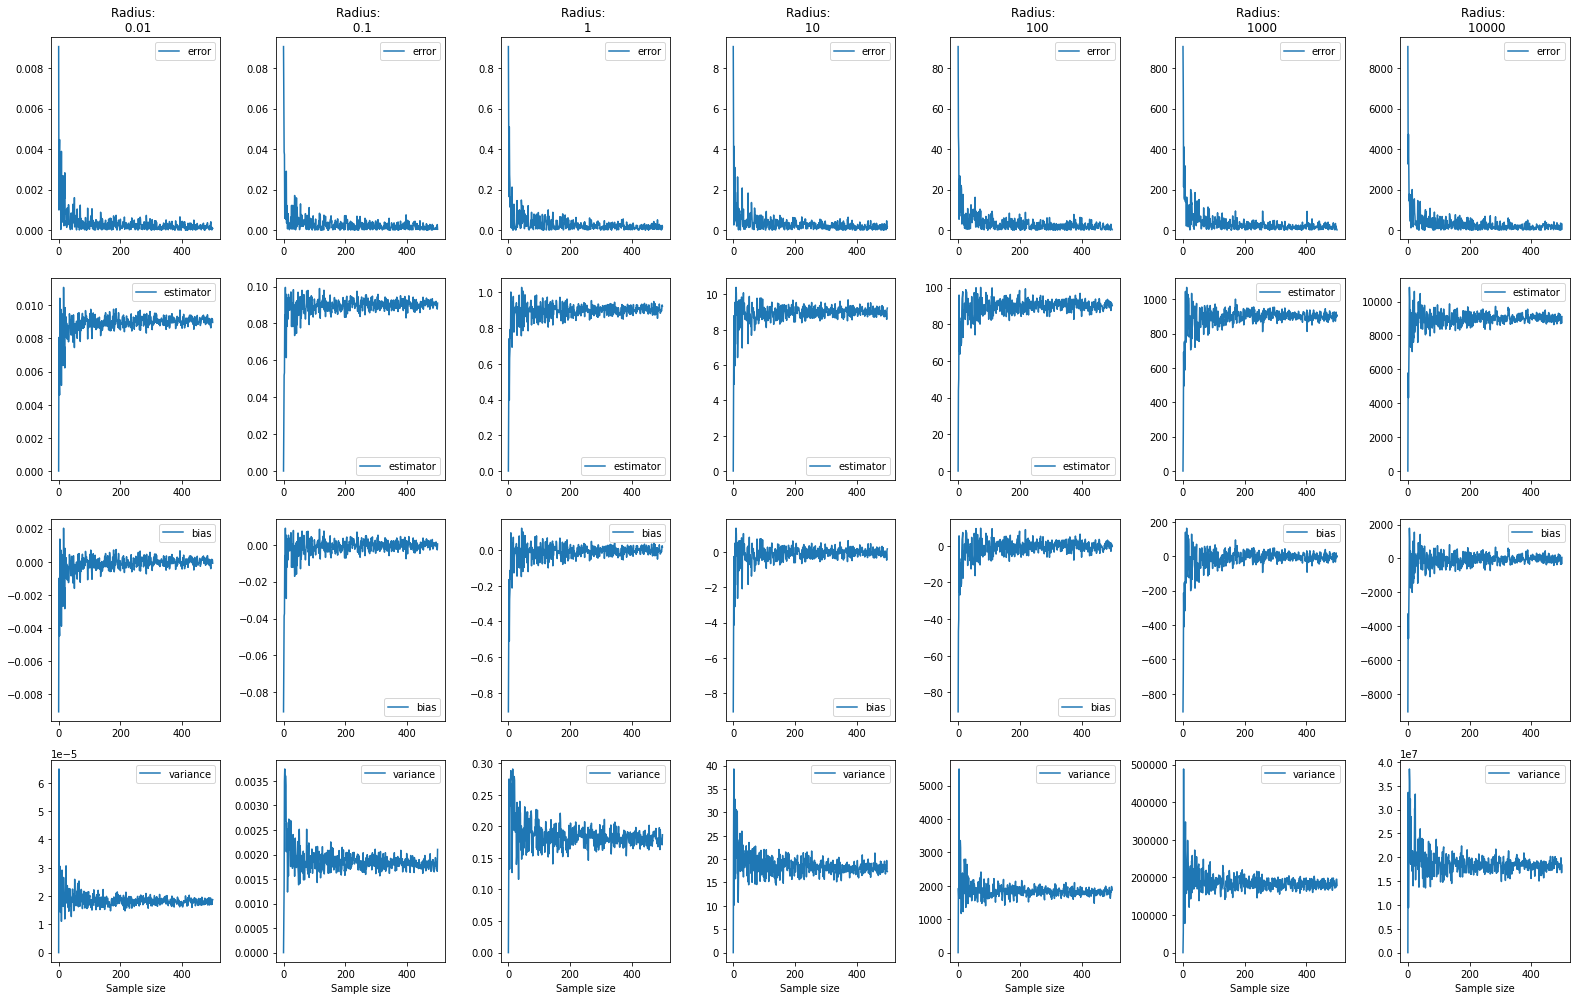

In [30]:
fig, ax = plt.subplots(nrows=4, ncols=7, figsize=(22, 14), tight_layout=True)

for idx, radius in enumerate(results.keys()):
    estimator = results[radius][0]
    error = results[radius][1]
    var_list = results[radius][2]
    bias_list = results[radius][3]
    
    ax[0, idx].plot(error, label='error')
    ax[0, idx].set_title(f'Radius: \n {radius}')
    ax[0, idx].legend()
    
    ax[1, idx].plot(estimator, label='estimator')
    ax[1, idx].legend()
    
    ax[2, idx].plot(bias_list, label='bias')
    ax[2, idx].legend()
    
    ax[3, idx].plot(var_list, label='variance')
    ax[3, idx].set_xlabel('Sample size')
    ax[3, idx].legend()

In [31]:
true_distance_value = true_distance(radius=1)

estimator_list = []
error_list = []
mcse_list = []
execution_time = []
var_list = []
for sample_size in tqdm(sample_size_list):
    
    start = time()
    
    point_one = gibbs_sampler(M=sample_size, radius=1)
    point_two = gibbs_sampler(M=sample_size, radius=1)

    empirical_distance = np.linalg.norm(point_one - point_two, axis=1) 

    estimator = np.mean(empirical_distance)
    error= np.abs(estimator - true_distance_value)
    mcse = np.std(empirical_distance) / sample_size
    var = np.var(empirical_distance)

    estimator_list.append(estimator)
    error_list.append(error)
    mcse_list.append(mcse)
    var_list.append(var)
    
    end = time()
    execution_time.append(end - start)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 592.44it/s]


In [32]:
running_mean = [np.mean(estimator_list[:idx]) for idx in range(1, len(estimator_list))]

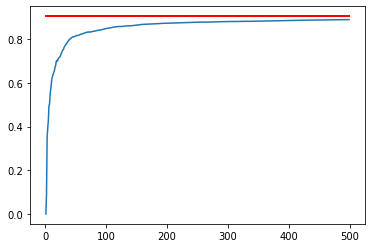

In [33]:
g = sns.lineplot(x=range(1, len(estimator_list)), y=running_mean)
plt.hlines(true_distance_value, xmin=0, xmax=len(sample_size_list), colors='r', linewidth=2, label='True value');

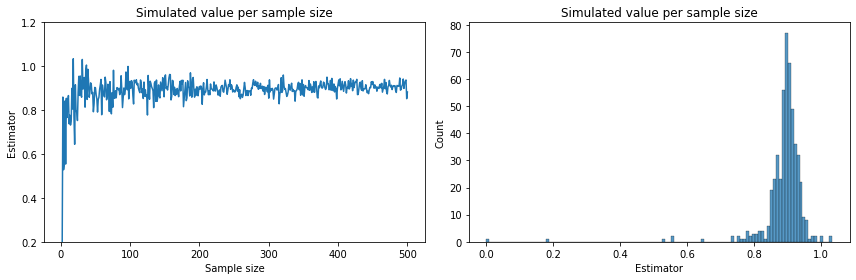

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), tight_layout=True)

sns.lineplot(x=sample_size_list, y=estimator_list, ax=ax[0])
ax[0].set_ylim((0.2, 1.2))
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Estimator')
ax[0].set_title('Simulated value per sample size')

sns.histplot(estimator_list, ax=ax[1])
ax[1].set_xlabel('Estimator')
ax[1].set_ylabel('Count')
ax[1].set_title('Simulated value per sample size');

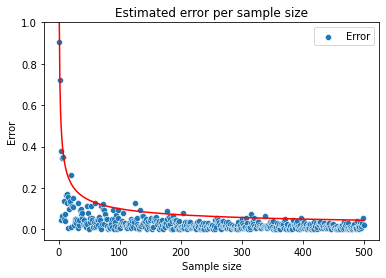

In [35]:
sns.scatterplot(x=sample_size_list, y=error_list, label='Error')
sns.lineplot(x=sample_size_list, y=[1./np.sqrt(n) for n in sample_size_list], color='r')
plt.ylim((-0.05,1.))
plt.xlabel('Sample size')
plt.ylabel('Error')
plt.title('Estimated error per sample size')
plt.legend();

In [45]:
running_time = [np.sum(execution_time[:idx]) for idx in range(1, len(execution_time))]

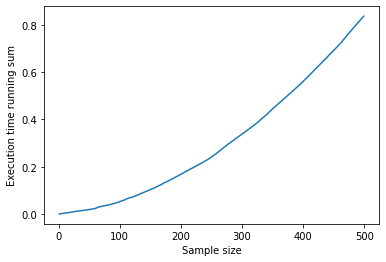

In [49]:
g = sns.lineplot(x=range(1, len(execution_time)), y=running_time)
plt.xlabel('Sample size') 
plt.ylabel('Execution time running sum');

In [37]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])

In [38]:
auto_corr = acf(point_one_sample[:, 0])

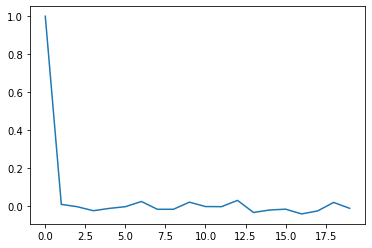

In [39]:
plt.plot(auto_corr);